In [26]:
%%capture
import delfi.distribution as dd
import delfi.utils.io as io
import numpy as np
import pickle

import delfi.inference as infer
import delfi.generator as dg
from delfi.simulator import GaussMixture
import delfi.summarystats as ds

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from parameters import ParameterSet
%run -i ../../DDELFI.py

import pickle

In [60]:
figs_dir = 'figs/'
output_dir = 'results/'

In [48]:
params = ParameterSet({})

seed = 42

params.res = ParameterSet({})
params.res.reinit_weights = True
params.res.n_components = 2
params.res.n_hiddens = [20]
params.res.svi = False

params.run = ParameterSet({})
params.run.n_train = 1000
params.run.minibatch = 100
params.n_gradients = 100000

params.model = ParameterSet({})

In [49]:
params.model.prior_bounds = (-1.5, 1.5)

output_prefix = 'unimodal_gaussian'

def create_model(seed, params):
    m = GaussMixture(dim=1, bimodal=False, noise_cov=[1.0, 0.01], seed=seed)
    p = dd.Uniform(lower=-10, upper=10, seed=seed)
    s = ds.Identity()
    g = dg.Default(model=m, prior=p, summary=s, seed=seed)
    
    obs = np.array([[0.]])
    
    p_true = dd.MoG(a=[0.5, 0.5], ms=[np.asarray([0.]), np.asarray([0.])], Ss=[1.0*np.eye(1), 0.01*np.eye(1)], seed=seed)

    return g, obs, p_true

In [53]:
def run_algo(algo, proposal, seed, params):
    g, obs, _ = create_model(seed, params)
    
    res_kwargs = {'generator': g, 
                  'reg_lambda': 0.01,
                  'verbose' : True,
                  'obs': obs.copy(),
                  'seed': seed}

    res_kwargs.update(params.res)
    
    cbk_feature_layer=0
    
    round_cl=999
    minibatch=100
    epochs = [params.n_gradients // (params.run.n_train//minibatch)]
    
    optim_data = None
    
    if algo == 'CDELFI':
        inf = infer.CDELFI(**res_kwargs)
        log, train_data, posteriors = inf.run(n_rounds=1,
                                              impute_proposal=proposal,
                                              epochs=epochs,
                                              **params.run)
    elif algo == 'SNPE':
        inf = infer.SNPE(**res_kwargs)
        log, train_data, posteriors = inf.run(n_rounds=1,
                                              impute_proposal=proposal,
                                              epochs=epochs,
                                              **params.run)     
    elif algo == 'kSNPE':
        inf = infer.SNPE(**res_kwargs)
        log, train_data, posteriors = inf.run(n_rounds=1,
                                              impute_proposal=proposal,
                                              epochs=epochs,
                                              kernel_loss='x_kl', 
                                              cbk_feature_layer=cbk_feature_layer,
                                              **params.run)
    elif algo == 'DDELFI':
        inf = DDELFI(**res_kwargs)
        log, train_data, posteriors, optim_data = inf.run(n_rounds=1,
                                                          impute_proposal=proposal,
                                                          epochs=epochs,
                                                          **params.run)   
    else:
        raise ValueError("Unknown algorithm '{}'".format(algo))
    
    return {'algo': algo,
            'seed': seed,
            'generator': g,
            'log': log,
            'obs' : obs, 
            'impute_proposal' : proposal,
            'train_data': train_data,
            'posteriors': posteriors,
            'network' : inf.network,
            'stats_std' : inf.stats_std,
            'stats_mean' : inf.stats_mean,
            'optim_data' : optim_data,
            'cbk_feature_layer' : cbk_feature_layer
           }

In [80]:
#T_dofs = [ 1, 2, 3, 5, 10 ]
#alphas = [ 0.01, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0 ]

T_dofs = []
alphas = [ 0.05, 0.1, 0.2, 0.3, 0.5 ]

def create_proposals(seed, params):
    g, _, p_true = create_model(seed, params)
    prior = g.prior
    
    prop_Ts = { "Student's T (df = {})".format(dofs) : p_true.convert_to_T(dofs) for dofs in T_dofs }
    prop_alphas = { "Defensive (a = {})".format(alpha) : DefensiveDistribution(p_true, prior, alpha) for alpha in alphas }
    
    post_std = np.diag(p_true.std)
    post_m = p_true.mean
    
    p_gauss = dd.Gaussian(m=post_m, S=post_std)
    ret = { "Prior" : prior, "Posterior" : p_true, "Gaussian Posterior" : p_gauss }
    ret.update(prop_Ts)
    ret.update(prop_alphas)
    return ret

In [57]:
proposals = create_proposals(seed, params)
algos = [ 'SNPE', 'kSNPE', 'DDELFI' ]
seeds = range(97, 147)

outs = { algo : { proposal : [] for proposal in proposals } for algo in algos }

for seed in seeds:
    for algo in algos:
        for proposal_name in proposals:
            print("Seed: {}".format(seed))
            print("Algorithm: {}".format(algo))
            print("Proposal Prior: {}".format(proposal_name))
            proposal = proposals[proposal_name]
            out = run_algo(algo, proposal, seed, params)
            outs[algo][proposal_name].append(out)

Seed: 97
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 97
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 97
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 97
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 97
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 97
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 97
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 97
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 97
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 97
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 97
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 97
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 97
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 97
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 97
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.06870651]: : 17it [00:00, 95.55it/s] 

loss=[-0.06870914]: : 1046it [00:06, 155.08it/s]


Seed: 97
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0606811]: : 17it [00:00, 114.85it/s] 

loss=[ 0.00821829]: : 1221it [00:07, 156.92it/s]


Seed: 97
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03689671]: : 17it [00:00, 98.78it/s] 

loss=[ 0.00038767]: : 1213it [00:07, 154.16it/s]


Seed: 97
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04522085]: : 17it [00:00, 120.65it/s]

loss=[ 0.00213361]: : 1286it [00:08, 157.17it/s]


Seed: 97
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07437253]: : 17it [00:00, 99.35it/s] 

loss=[-0.01011276]: : 4218it [00:25, 162.58it/s]   


Seed: 97
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07062006]: : 17it [00:00, 118.43it/s]

loss=[ 0.00573564]: : 1517it [00:09, 158.92it/s]


Seed: 97
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.14388371]: : 15it [00:00, 103.26it/s]

loss=[-0.00321245]: : 4105it [00:29, 140.07it/s]    


Seed: 98
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 98
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 98
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 98
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 98
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 98
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 98
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 98
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 98
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 98
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 98
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 98
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 98
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 98
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 98
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.03141618]: : 16it [00:00, 89.08it/s] 

loss=[-0.03141761]: : 1052it [00:07, 148.48it/s]


Seed: 98
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04545426]: : 18it [00:00, 128.00it/s]

loss=[-0.00771403]: : 1271it [00:08, 157.53it/s]   


Seed: 98
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0283761]: : 17it [00:00, 98.78it/s]  

loss=[ 0.00175452]: : 1154it [00:08, 138.75it/s]


Seed: 98
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03944612]: : 17it [00:00, 100.38it/s]

loss=[-0.0126524]: : 1238it [00:08, 146.51it/s]    


Seed: 98
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07213807]: : 17it [00:00, 117.53it/s]

loss=[ 0.00128889]: : 1476it [00:10, 139.11it/s]


Seed: 98
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03163719]: : 17it [00:00, 116.55it/s]

loss=[-0.01508498]: : 1249it [00:07, 156.18it/s]


Seed: 98
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04940438]: : 17it [00:00, 96.38it/s] 

loss=[ 0.00144458]: : 1308it [00:08, 151.54it/s]


Seed: 99
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 99
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 99
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 99
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 99
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 99
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 99
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 99
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 99
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 99
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 99
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 99
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 99
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 99
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 99
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.02976727]: : 15it [00:00, 119.35it/s]

loss=[-0.02981186]: : 1048it [00:07, 137.84it/s]


Seed: 99
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06184649]: : 14it [00:00, 121.39it/s]

loss=[-0.00287175]: : 1250it [00:08, 147.39it/s]    


Seed: 99
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06188846]: : 16it [00:00, 117.84it/s]

loss=[-0.01843524]: : 1511it [00:10, 150.88it/s]


Seed: 99
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03622961]: : 18it [00:00, 104.73it/s]

loss=[-0.00559545]: : 1242it [00:07, 156.68it/s]    


Seed: 99
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04767871]: : 16it [00:00, 93.74it/s] 

loss=[-0.00333357]: : 1343it [00:08, 153.98it/s]   


Seed: 99
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0763576]: : 16it [00:00, 95.15it/s]  

loss=[-0.00750351]: : 1461it [00:09, 158.69it/s]   


Seed: 99
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.09772396]: : 17it [00:00, 115.78it/s]

loss=[ 0.02100563]: : 1650it [00:10, 153.40it/s]


Seed: 100
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 100
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 100
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 100
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 100
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 100
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 100
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 100
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 100
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 100
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 100
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 100
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 100
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 100
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 100
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.08632636]: : 18it [00:00, 99.40it/s] 

loss=[-0.08633256]: : 1037it [00:06, 163.00it/s]


Seed: 100
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05176044]: : 17it [00:00, 127.07it/s]

loss=[ -6.29425049e-05]: : 1261it [00:08, 156.97it/s]


Seed: 100
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06510663]: : 17it [00:00, 102.38it/s]

loss=[ 0.0187974]: : 1223it [00:07, 154.93it/s] 


Seed: 100
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.12966681]: : 18it [00:00, 128.37it/s]

loss=[ 0.01737738]: : 2047it [00:12, 162.09it/s]


Seed: 100
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06814861]: : 16it [00:00, 96.17it/s] 

loss=[ 0.01331687]: : 1345it [00:08, 152.79it/s]


Seed: 100
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03972292]: : 16it [00:00, 94.15it/s] 

loss=[-0.01070881]: : 1461it [00:09, 151.43it/s]


Seed: 100
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04826665]: : 17it [00:00, 98.94it/s] 

loss=[-0.00481939]: : 2291it [00:14, 153.95it/s]   


Seed: 101
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 101
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 101
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 101
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 101
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 101
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 101
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 101
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 101
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 101
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 101
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 101
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 101
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 101
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 101
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.01061702]: : 17it [00:00, 114.35it/s]

loss=[-0.01060677]: : 1007it [00:06, 157.78it/s]


Seed: 101
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.00393891]: : 17it [00:00, 119.77it/s]

loss=[-0.01107812]: : 1136it [00:07, 153.55it/s]   


Seed: 101
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01252389]: : 17it [00:00, 100.75it/s]

loss=[-0.00545168]: : 1152it [00:07, 154.00it/s]   


Seed: 101
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07871962]: : 17it [00:00, 99.20it/s] 

loss=[ 0.02594328]: : 2570it [00:16, 155.02it/s]


Seed: 101
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02705359]: : 17it [00:00, 113.93it/s]

loss=[-0.00499654]: : 1157it [00:07, 155.85it/s]   


Seed: 101
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02870226]: : 17it [00:00, 118.53it/s]

loss=[-0.00362635]: : 1156it [00:07, 163.15it/s]   


Seed: 101
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.10101819]: : 17it [00:00, 113.14it/s]

loss=[ 0.00466871]: : 1783it [00:11, 159.86it/s]


Seed: 102
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 102
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 102
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 102
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 102
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 102
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 102
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 102
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 102
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 102
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 102
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 102
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 102
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 102
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 102
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00686216]: : 18it [00:00, 120.49it/s]

loss=[-0.00688052]: : 1056it [00:06, 164.66it/s]


Seed: 102
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04381323]: : 18it [00:00, 127.65it/s]

loss=[-0.00148296]: : 1225it [00:07, 162.29it/s]    


Seed: 102
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01549149]: : 18it [00:00, 119.06it/s]

loss=[-0.0091536]: : 1156it [00:07, 161.39it/s]    


Seed: 102
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03953648]: : 18it [00:00, 129.72it/s]

loss=[-0.00865746]: : 1269it [00:07, 161.80it/s]   


Seed: 102
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06856441]: : 16it [00:00, 114.37it/s]

loss=[-0.00797367]: : 1324it [00:08, 163.53it/s]    


Seed: 102
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05335903]: : 17it [00:00, 98.08it/s] 

loss=[ 0.01198936]: : 1207it [00:07, 163.59it/s]


Seed: 102
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0580554]: : 17it [00:00, 96.83it/s]  

loss=[-0.00764227]: : 1317it [00:08, 158.87it/s]


Seed: 103
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 103
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 103
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 103
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 103
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 103
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 103
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 103
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 103
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 103
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 103
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 103
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 103
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 103
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 103
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.00042939]: : 15it [00:00, 83.34it/s] 

loss=[ 0.00037646]: : 1071it [00:07, 137.96it/s]


Seed: 103
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08033323]: : 16it [00:00, 93.02it/s] 

loss=[ 0.00086641]: : 1579it [00:10, 153.40it/s]


Seed: 103
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06218386]: : 18it [00:00, 128.19it/s]

loss=[ 0.02139783]: : 1171it [00:07, 160.42it/s]


Seed: 103
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04294419]: : 17it [00:00, 98.94it/s] 

loss=[ 0.015486]: : 1225it [00:07, 158.88it/s]  


Seed: 103
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05589533]: : 17it [00:00, 121.43it/s]

loss=[ 0.00217652]: : 1212it [00:07, 155.46it/s]


Seed: 103
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04013634]: : 15it [00:00, 110.92it/s]

loss=[-0.01147079]: : 1341it [00:09, 142.14it/s]


Seed: 103
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08410454]: : 15it [00:00, 85.93it/s] 

loss=[ 0.013762]: : 1342it [00:09, 135.82it/s]  


Seed: 104
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 104
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 104
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 104
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 104
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 104
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 104
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 104
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 104
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 104
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 104
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 104
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 104
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 104
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 104
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.03860402]: : 17it [00:00, 94.17it/s] 

loss=[-0.03860927]: : 1051it [00:07, 147.79it/s]


Seed: 104
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03885198]: : 16it [00:00, 94.75it/s] 

loss=[-0.00300145]: : 1249it [00:08, 140.34it/s]    


Seed: 104
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07499576]: : 15it [00:00, 118.43it/s]

loss=[ 0.0083034]: : 1341it [00:09, 136.16it/s] 


Seed: 104
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0798614]: : 15it [00:00, 105.84it/s] 

loss=[-0.00988197]: : 1423it [00:14, 98.76it/s] 


Seed: 104
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0686245]: : 14it [00:00, 84.70it/s]  

loss=[-0.0031054]: : 1414it [00:10, 130.32it/s]     


Seed: 104
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06332517]: : 14it [00:00, 81.51it/s] 

loss=[-0.00850463]: : 1434it [00:11, 124.35it/s]   


Seed: 104
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.15046501]: : 16it [00:00, 113.26it/s]

loss=[-0.00258708]: : 5217it [00:36, 142.46it/s]     


Seed: 105
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 105
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 105
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 105
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 105
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 105
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 105
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 105
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 105
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 105
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 105
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 105
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 105
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 105
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 105
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03138733]: : 17it [00:00, 94.05it/s] 

loss=[ 0.03138447]: : 1015it [00:06, 150.68it/s]


Seed: 105
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03651333]: : 16it [00:00, 96.59it/s] 

loss=[ 0.00669765]: : 1190it [00:08, 144.36it/s]


Seed: 105
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03720069]: : 17it [00:00, 101.25it/s]

loss=[ 0.00741982]: : 1202it [00:08, 148.83it/s]


Seed: 105
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.09688926]: : 16it [00:00, 117.88it/s]

loss=[ 0.00561833]: : 1691it [00:11, 146.78it/s]


Seed: 105
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.09009457]: : 16it [00:00, 110.63it/s]

loss=[ 0.01070619]: : 1400it [00:09, 147.33it/s]


Seed: 105
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06726408]: : 15it [00:00, 88.77it/s] 

loss=[ 0.01144433]: : 1177it [00:08, 137.45it/s]


Seed: 105
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07332754]: : 17it [00:00, 111.41it/s]

loss=[ 0.00109792]: : 1288it [00:08, 144.57it/s]


Seed: 106
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 106
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 106
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 106
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 106
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 106
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 106
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 106
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 106
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 106
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 106
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 106
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 106
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 106
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 106
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.06251097]: : 18it [00:00, 122.33it/s]

loss=[-0.06258416]: : 1036it [00:06, 158.96it/s]


Seed: 106
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03631496]: : 17it [00:00, 122.90it/s]

loss=[-0.0019803]: : 1198it [00:07, 157.42it/s]    


Seed: 106
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07688498]: : 17it [00:00, 122.26it/s]

loss=[-0.00410891]: : 1493it [00:09, 157.52it/s]    


Seed: 106
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01531911]: : 16it [00:00, 95.35it/s] 

loss=[-0.00919437]: : 1152it [00:07, 151.37it/s]   


Seed: 106
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04087567]: : 16it [00:00, 108.91it/s]

loss=[-0.00297117]: : 1249it [00:09, 135.51it/s]   


Seed: 106
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04835963]: : 17it [00:00, 118.53it/s]

loss=[-0.01824403]: : 1363it [00:09, 144.73it/s]


Seed: 106
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03022242]: : 17it [00:00, 111.91it/s]

loss=[-0.01636481]: : 1301it [00:08, 145.90it/s]   


Seed: 107
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 107
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 107
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 107
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 107
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 107
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 107
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 107
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 107
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 107
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 107
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 107
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 107
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 107
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 107
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.04384375]: : 17it [00:00, 93.17it/s] 

loss=[-0.04384756]: : 1046it [00:06, 151.68it/s]


Seed: 107
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08913064]: : 16it [00:00, 96.95it/s] 

loss=[ 0.00494552]: : 1431it [00:09, 151.95it/s]


Seed: 107
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.00393963]: : 1272it [00:10, 118.03it/s]


Seed: 107
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06133127]: : 16it [00:00, 137.34it/s]

loss=[-0.01185894]: : 1274it [00:09, 137.61it/s]   


Seed: 107
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08936]: : 17it [00:00, 128.24it/s]   

loss=[ 0.00800204]: : 1360it [00:08, 156.97it/s]


Seed: 107
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0808177]: : 17it [00:00, 123.76it/s] 

loss=[ 0.00779629]: : 1313it [00:08, 161.27it/s]


Seed: 107
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.14883471]: : 16it [00:00, 92.82it/s] 

loss=[-0.00801325]: : 4866it [00:33, 146.58it/s]    


Seed: 108
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 108
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 108
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 108
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 108
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 108
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 108
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 108
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 108
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 108
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 108
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 108
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 108
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 108
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 108
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.00842214]: : 17it [00:00, 118.68it/s]

loss=[ 0.00842214]: : 1005it [00:06, 158.26it/s]


Seed: 108
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01563263]: : 18it [00:00, 104.28it/s]

loss=[-0.0103457]: : 1178it [00:07, 158.28it/s] 


Seed: 108
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04821372]: : 18it [00:00, 122.80it/s]

loss=[-0.00239205]: : 1245it [00:07, 161.47it/s]    


Seed: 108
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04558825]: : 17it [00:00, 99.13it/s] 

loss=[ 0.00145006]: : 1413it [00:08, 160.56it/s]


Seed: 108
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08230948]: : 17it [00:00, 116.72it/s]

loss=[ 0.01938581]: : 1286it [00:08, 160.48it/s]


Seed: 108
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04080534]: : 17it [00:00, 97.45it/s] 

loss=[-0.00118828]: : 1238it [00:07, 162.09it/s]    


Seed: 108
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03074002]: : 17it [00:00, 95.81it/s] 

loss=[-0.01851916]: : 1392it [00:08, 157.95it/s]


Seed: 109
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 109
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 109
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 109
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 109
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 109
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 109
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 109
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 109
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 109
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 109
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 109
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 109
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 109
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 109
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04335928]: : 18it [00:00, 127.53it/s]

loss=[ 0.04333496]: : 1054it [00:07, 145.69it/s]


Seed: 109
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.10601616]: : 14it [00:00, 127.63it/s]

loss=[ 0.00614834]: : 1423it [00:09, 151.32it/s]


Seed: 109
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.17217946]: : 17it [00:00, 127.07it/s]

loss=[ 0.01477098]: : 4279it [00:27, 157.93it/s]


Seed: 109
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.13511968]: : 17it [00:00, 125.68it/s]

loss=[ 0.00293422]: : 5198it [00:33, 154.23it/s]


Seed: 109
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08539248]: : 17it [00:00, 99.20it/s] 

loss=[-0.00872707]: : 4367it [00:28, 154.28it/s]


Seed: 109
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.14678812]: : 17it [00:00, 98.64it/s] 

loss=[ 0.01083636]: : 5775it [00:39, 145.55it/s]


Seed: 109
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08056521]: : 17it [00:00, 119.49it/s]

loss=[-0.02797222]: : 3581it [00:24, 143.63it/s]   


Seed: 110
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 110
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 110
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 110
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 110
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 110
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 110
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 110
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 110
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 110
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 110
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 110
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 110
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 110
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 110
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.04178786]: : 17it [00:00, 124.67it/s]

loss=[-0.0417943]: : 1052it [00:07, 135.07it/s] 


Seed: 110
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04398417]: : 16it [00:00, 131.37it/s]

loss=[ 0.00101614]: : 1205it [00:08, 139.25it/s]


Seed: 110
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03887129]: : 16it [00:00, 128.29it/s]

loss=[-0.01325274]: : 1393it [00:10, 138.39it/s]   


Seed: 110
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03636503]: : 16it [00:00, 128.44it/s]

loss=[-0.00697184]: : 1362it [00:09, 140.96it/s]   


Seed: 110
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08138704]: : 16it [00:00, 124.90it/s]

loss=[ 0.00832987]: : 1511it [00:10, 142.14it/s]


Seed: 110
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06282496]: : 16it [00:00, 124.30it/s]

loss=[-0.00357485]: : 1323it [00:09, 142.90it/s]   


Seed: 110
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.059587]: : 15it [00:00, 111.71it/s]  

loss=[ 0.01090479]: : 1203it [00:08, 141.90it/s]


Seed: 111
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 111
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 111
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 111
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 111
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 111
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 111
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 111
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 111
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 111
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 111
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 111
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 111
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 111
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 111
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0112896]: : 16it [00:00, 105.27it/s] 

loss=[ 0.01128936]: : 1024it [00:07, 140.48it/s]


Seed: 111
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02655506]: : 15it [00:00, 91.26it/s] 

loss=[-0.00552034]: : 1164it [00:08, 137.98it/s]   


Seed: 111
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05569792]: : 14it [00:00, 116.40it/s]

loss=[-0.00704694]: : 1208it [00:09, 128.55it/s]   


Seed: 111
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02376437]: : 17it [00:00, 101.41it/s]

loss=[-0.00282264]: : 1157it [00:07, 148.28it/s]   


Seed: 111
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06558514]: : 15it [00:00, 90.63it/s] 

loss=[-0.00524116]: : 1332it [00:09, 140.55it/s]    


Seed: 111
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08096004]: : 16it [00:00, 93.13it/s] 

loss=[ 0.0041604]: : 2731it [00:18, 150.08it/s] 


Seed: 111
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.10156679]: : 16it [00:00, 90.98it/s] 

loss=[ 0.00752401]: : 2250it [00:15, 146.23it/s]


Seed: 112
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 112
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 112
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 112
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 112
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 112
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 112
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 112
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 112
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 112
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 112
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 112
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 112
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 112
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 112
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.01436305]: : 16it [00:00, 91.56it/s] 

loss=[-0.01438856]: : 1042it [00:07, 145.13it/s]


Seed: 112
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07930231]: : 16it [00:00, 92.48it/s] 

loss=[ 0.00288081]: : 1439it [00:10, 141.59it/s]


Seed: 112
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.13768172]: : 16it [00:00, 93.83it/s] 

loss=[ 0.01282644]: : 3295it [00:22, 144.10it/s]


Seed: 112
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.10816908]: : 15it [00:00, 88.02it/s] 

loss=[ 0.00955629]: : 2978it [00:21, 137.44it/s]


Seed: 112
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06876731]: : 15it [00:00, 87.85it/s] 

loss=[ 0.00377035]: : 1355it [00:10, 134.87it/s]


Seed: 112
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08205509]: : 16it [00:00, 91.96it/s] 

loss=[ 0.00350499]: : 1741it [00:13, 133.81it/s]


Seed: 112
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07248211]: : 16it [00:00, 92.54it/s] 

loss=[-0.01988888]: : 1407it [00:09, 146.00it/s]   


Seed: 113
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 113
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 113
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 113
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 113
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 113
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 113
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 113
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 113
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 113
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 113
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 113
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 113
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 113
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 113
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.0724113]: : 16it [00:00, 111.36it/s] 

loss=[-0.07241893]: : 1032it [00:07, 142.04it/s]


Seed: 113
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05028105]: : 16it [00:00, 95.53it/s] 

loss=[ 0.015522]: : 3105it [00:22, 139.39it/s]  


Seed: 113
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02961421]: : 15it [00:00, 89.24it/s] 

loss=[ 0.00500488]: : 1162it [00:08, 140.75it/s]


Seed: 113
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02636147]: : 15it [00:00, 109.62it/s]

loss=[-0.01161122]: : 1195it [00:07, 153.49it/s]


Seed: 113
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07118964]: : 16it [00:00, 95.27it/s] 

loss=[-0.00988436]: : 1969it [00:13, 142.35it/s]


Seed: 113
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04171395]: : 16it [00:00, 114.65it/s]

loss=[-0.01608467]: : 1277it [00:09, 140.82it/s]


Seed: 113
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.11916351]: : 16it [00:00, 91.31it/s] 

loss=[-0.0004611]: : 3464it [00:24, 139.56it/s]     


Seed: 114
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 114
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 114
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 114
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 114
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 114
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 114
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 114
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 114
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 114
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 114
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 114
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 114
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 114
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 114
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.03554845]: : 16it [00:00, 89.39it/s] 

loss=[-0.03557873]: : 1049it [00:07, 143.31it/s]


Seed: 114
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04190731]: : 16it [00:00, 95.15it/s] 

loss=[-0.00278234]: : 1227it [00:08, 140.88it/s]    


Seed: 114
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04585218]: : 16it [00:00, 93.79it/s] 

loss=[-0.00429273]: : 1344it [00:09, 138.14it/s]    


Seed: 114
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03902888]: : 16it [00:00, 95.85it/s] 

loss=[ 0.00492716]: : 1279it [00:09, 140.23it/s]


Seed: 114
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07870054]: : 15it [00:00, 89.04it/s] 

loss=[ 0.00347471]: : 1589it [00:11, 142.18it/s]


Seed: 114
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06038475]: : 15it [00:00, 88.20it/s] 

loss=[-0.00863791]: : 1580it [00:11, 138.87it/s]    


Seed: 114
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08982801]: : 16it [00:00, 91.34it/s] 

loss=[-0.00444365]: : 2459it [00:17, 138.09it/s]    


Seed: 115
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 115
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 115
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 115
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 115
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 115
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 115
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 115
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 115
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 115
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 115
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 115
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 115
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 115
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 115
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.06137824]: : 17it [00:00, 92.56it/s] 

loss=[-0.0613873]: : 1043it [00:07, 148.90it/s] 


Seed: 115
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04634738]: : 16it [00:00, 149.92it/s]

loss=[-0.00122523]: : 1160it [00:08, 135.59it/s]    


Seed: 115
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02198029]: : 15it [00:00, 89.55it/s] 

loss=[-0.00981569]: : 1210it [00:09, 134.10it/s]


Seed: 115
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07419634]: : 15it [00:00, 90.15it/s] 

loss=[ 0.00735116]: : 1297it [00:09, 135.72it/s]


Seed: 115
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0376451]: : 16it [00:00, 115.09it/s] 

loss=[-0.00384355]: : 1191it [00:08, 140.11it/s]   


Seed: 115
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0533452]: : 14it [00:00, 115.71it/s] 

loss=[ 0.00918794]: : 1169it [00:08, 142.25it/s]


Seed: 115
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05999017]: : 15it [00:00, 115.22it/s]

loss=[ 0.0051856]: : 1192it [00:09, 132.22it/s] 


Seed: 116
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 116
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 116
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 116
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 116
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 116
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 116
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 116
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 116
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 116
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 116
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 116
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 116
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 116
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 116
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.06273794]: : 16it [00:00, 87.29it/s] 

loss=[-0.06277514]: : 1067it [00:07, 143.29it/s]


Seed: 116
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.041605]: : 15it [00:00, 90.80it/s]   

loss=[ 0.00817442]: : 1148it [00:08, 139.92it/s]


Seed: 116
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.11004138]: : 15it [00:00, 92.29it/s] 

loss=[-0.00066948]: : 2536it [00:18, 140.86it/s]    


Seed: 116
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.14564514]: : 16it [00:00, 112.29it/s]

loss=[ 0.00147891]: : 3882it [00:27, 142.12it/s]


Seed: 116
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.1428194]: : 14it [00:00, 83.35it/s]  

loss=[ 0.002285]: : 5188it [00:37, 139.25it/s]  


Seed: 116
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03033686]: : 15it [00:00, 88.99it/s] 

loss=[ 0.00109363]: : 1167it [00:07, 148.05it/s]


Seed: 116
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0583396]: : 15it [00:00, 88.67it/s]  

loss=[-0.00577021]: : 1819it [00:13, 136.92it/s]   


Seed: 117
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 117
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 117
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 117
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 117
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 117
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 117
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 117
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 117
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 117
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 117
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 117
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 117
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 117
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 117
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03214121]: : 16it [00:00, 109.44it/s]

loss=[ 0.03210497]: : 1066it [00:07, 141.42it/s]


Seed: 117
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.09201789]: : 15it [00:00, 112.53it/s]

loss=[ 0.00355077]: : 1735it [00:12, 138.52it/s]


Seed: 117
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08942962]: : 14it [00:00, 78.48it/s] 

loss=[-0.00648737]: : 1956it [00:14, 137.75it/s]    


Seed: 117
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0702107]: : 16it [00:00, 95.15it/s]  

loss=[ 0.00146508]: : 1695it [00:12, 136.68it/s]


Seed: 117
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01923609]: : 15it [00:00, 90.05it/s] 

loss=[-0.01329255]: : 1237it [00:08, 141.72it/s]


Seed: 117
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08424783]: : 15it [00:00, 85.93it/s] 

loss=[ 0.01118088]: : 1532it [00:11, 136.57it/s]


Seed: 117
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.09105873]: : 15it [00:00, 103.18it/s]

loss=[ 0.00749397]: : 1368it [00:09, 140.09it/s]


Seed: 118
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 118
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 118
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 118
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 118
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 118
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 118
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 118
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 118
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 118
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 118
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 118
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 118
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 118
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 118
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.03242326]: : 15it [00:00, 82.55it/s] 

loss=[-0.0324235]: : 1035it [00:07, 141.72it/s] 


Seed: 118
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05286908]: : 14it [00:00, 102.66it/s]

loss=[ 0.00815558]: : 1166it [00:08, 137.17it/s]


Seed: 118
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03302932]: : 15it [00:00, 105.20it/s]

loss=[-0.00627351]: : 1264it [00:09, 139.98it/s]   


Seed: 118
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03311992]: : 16it [00:00, 94.16it/s] 

loss=[ 0.0050621]: : 1157it [00:08, 136.49it/s]


Seed: 118
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07128215]: : 15it [00:00, 89.21it/s] 

loss=[ 0.01534033]: : 1274it [00:09, 136.83it/s]


Seed: 118
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06436825]: : 15it [00:00, 87.34it/s] 

loss=[ 0.01141262]: : 1345it [00:09, 134.86it/s]


Seed: 118
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.19447803]: : 16it [00:00, 92.08it/s] 

loss=[ 0.01719093]: : 5724it [00:41, 137.93it/s]


Seed: 119
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 119
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 119
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 119
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 119
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 119
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 119
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 119
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 119
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 119
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 119
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 119
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 119
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 119
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 119
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00957346]: : 15it [00:00, 83.42it/s] 

loss=[-0.00960231]: : 1039it [00:07, 142.74it/s]


Seed: 119
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01676679]: : 16it [00:00, 88.06it/s] 

loss=[-0.00924397]: : 1175it [00:08, 138.17it/s]   


Seed: 119
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05092311]: : 17it [00:00, 102.04it/s]

loss=[ 0.00041127]: : 1196it [00:08, 147.17it/s]


Seed: 119
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04600191]: : 18it [00:00, 131.35it/s]

loss=[-0.001513]: : 1256it [00:08, 143.38it/s]      


Seed: 119
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01023984]: : 17it [00:00, 100.42it/s]

loss=[-0.01490712]: : 1144it [00:08, 136.83it/s]


Seed: 119
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03204513]: : 16it [00:00, 93.43it/s] 

loss=[-0.00519967]: : 1271it [00:09, 136.11it/s]    


Seed: 119
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06115294]: : 16it [00:00, 108.49it/s]

loss=[-0.01473141]: : 1635it [00:11, 144.53it/s]


Seed: 120
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 120
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 120
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 120
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 120
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 120
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 120
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 120
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 120
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 120
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 120
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 120
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 120
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 120
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 120
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.05213284]: : 15it [00:00, 84.71it/s] 

loss=[-0.05213714]: : 1033it [00:07, 141.40it/s]


Seed: 120
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03232169]: : 14it [00:00, 84.30it/s] 

loss=[ 0.00477338]: : 1153it [00:08, 134.54it/s]


Seed: 120
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0411315]: : 14it [00:00, 84.88it/s]  

loss=[-0.00855398]: : 1261it [00:09, 134.18it/s]


Seed: 120
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0422349]: : 17it [00:00, 99.46it/s]  

loss=[-0.00373983]: : 1353it [00:09, 147.47it/s]   


Seed: 120
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06537485]: : 15it [00:00, 106.03it/s]

loss=[-0.00446749]: : 1366it [00:09, 139.56it/s]    


Seed: 120
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.1085968]: : 15it [00:00, 89.89it/s]  

loss=[ 0.00247455]: : 3113it [00:22, 136.37it/s]


Seed: 120
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.1352253]: : 13it [00:00, 75.26it/s]  

loss=[ 0.01161766]: : 3193it [00:23, 133.49it/s]


Seed: 121
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 121
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 121
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 121
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 121
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 121
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 121
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 121
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 121
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 121
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 121
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 121
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 121
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 121
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 121
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.04382563]: : 17it [00:00, 118.96it/s]

loss=[-0.04387975]: : 1038it [00:07, 142.65it/s]


Seed: 121
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0451951]: : 17it [00:00, 103.02it/s] 

loss=[ 0.00271368]: : 1340it [00:09, 138.91it/s]


Seed: 121
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.00649047]: : 16it [00:00, 94.73it/s] 

loss=[-0.01839161]: : 1169it [00:08, 140.72it/s]


Seed: 121
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04066229]: : 17it [00:00, 100.37it/s]

loss=[ 0.00335813]: : 1197it [00:07, 159.24it/s]


Seed: 121
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05310154]: : 16it [00:00, 94.09it/s] 

loss=[  7.82012939e-05]: : 1205it [00:08, 141.74it/s]


Seed: 121
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05762219]: : 15it [00:00, 86.65it/s] 

loss=[ 0.01367331]: : 1263it [00:09, 136.25it/s]


Seed: 121
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.14031601]: : 16it [00:00, 92.39it/s] 

loss=[-0.00469208]: : 7050it [00:50, 138.37it/s]    


Seed: 122
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 122
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 122
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 122
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 122
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 122
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 122
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 122
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 122
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 122
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 122
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 122
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 122
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 122
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 122
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.04973221]: : 16it [00:00, 89.05it/s] 

loss=[-0.04973269]: : 1020it [00:07, 142.14it/s]


Seed: 122
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04532933]: : 16it [00:00, 94.10it/s] 

loss=[-0.0014503]: : 2685it [00:19, 139.55it/s]     


Seed: 122
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06527996]: : 16it [00:00, 96.76it/s] 

loss=[-0.00213075]: : 1506it [00:10, 138.72it/s]    


Seed: 122
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08017635]: : 16it [00:00, 96.33it/s] 

loss=[ 0.00638819]: : 1610it [00:11, 137.65it/s]


Seed: 122
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03512597]: : 15it [00:00, 88.31it/s] 

loss=[ 0.00682688]: : 1201it [00:08, 138.77it/s]


Seed: 122
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04329014]: : 15it [00:00, 89.88it/s] 

loss=[-0.01106119]: : 1323it [00:09, 141.12it/s]


Seed: 122
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.13505411]: : 15it [00:00, 85.46it/s] 

loss=[ 0.01087618]: : 8599it [01:03, 135.44it/s]


Seed: 123
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 123
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 123
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 123
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 123
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 123
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 123
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 123
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 123
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 123
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 123
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 123
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 123
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 123
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 123
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.01183438]: : 18it [00:00, 100.50it/s]

loss=[-0.01186252]: : 1042it [00:07, 145.18it/s]


Seed: 123
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02971888]: : 17it [00:00, 101.23it/s]

loss=[-0.00324512]: : 1170it [00:07, 150.84it/s]    


Seed: 123
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07651114]: : 16it [00:00, 94.52it/s] 

loss=[ 0.01038361]: : 1398it [00:09, 151.73it/s]


Seed: 123
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05889702]: : 17it [00:00, 100.82it/s]

loss=[ 0.00650477]: : 1428it [00:08, 159.24it/s]


Seed: 123
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03198385]: : 16it [00:00, 88.71it/s] 

loss=[ 0.00121069]: : 1159it [00:08, 139.59it/s]


Seed: 123
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0561707]: : 16it [00:00, 95.78it/s]  

loss=[ 0.00374508]: : 1313it [00:09, 137.76it/s]


Seed: 123
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0933187]: : 15it [00:00, 87.14it/s]  

loss=[-0.00727987]: : 1578it [00:11, 142.41it/s]    


Seed: 124
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 124
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 124
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 124
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 124
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 124
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 124
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 124
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 124
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 124
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 124
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 124
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 124
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 124
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 124
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.06480122]: : 15it [00:00, 83.66it/s] 

loss=[-0.0648191]: : 1047it [00:07, 140.40it/s] 


Seed: 124
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07550406]: : 17it [00:00, 100.63it/s]

loss=[-0.00079536]: : 1511it [00:10, 138.07it/s]    


Seed: 124
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.13631487]: : 16it [00:00, 94.90it/s] 

loss=[-0.00142765]: : 4618it [00:32, 140.76it/s]    


Seed: 124
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04390907]: : 17it [00:00, 102.16it/s]

loss=[  6.81877136e-05]: : 1320it [00:08, 151.95it/s]


Seed: 124
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.13191915]: : 16it [00:00, 95.09it/s] 

loss=[ 0.00652313]: : 4431it [00:31, 139.46it/s]


Seed: 124
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.14991045]: : 17it [00:00, 97.77it/s] 

loss=[ 0.02316403]: : 3286it [00:22, 145.66it/s]


Seed: 124
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04389024]: : 16it [00:00, 92.73it/s] 

loss=[-0.00592327]: : 1644it [00:11, 137.97it/s]   


Seed: 125
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 125
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 125
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 125
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 125
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 125
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 125
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 125
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 125
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 125
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 125
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 125
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 125
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 125
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 125
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00184703]: : 16it [00:00, 89.83it/s] 

loss=[-0.00187302]: : 1058it [00:07, 145.33it/s]


Seed: 125
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0383122]: : 18it [00:00, 131.28it/s] 

loss=[ 0.00896335]: : 1332it [00:08, 158.28it/s]


Seed: 125
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03935862]: : 17it [00:00, 117.86it/s]

loss=[-0.00788331]: : 1189it [00:08, 142.48it/s]   


Seed: 125
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03111625]: : 16it [00:00, 118.19it/s]

loss=[-0.01089621]: : 1167it [00:08, 141.45it/s]   


Seed: 125
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0323956]: : 16it [00:00, 94.20it/s]  

loss=[-0.00497222]: : 1161it [00:08, 141.04it/s]   


Seed: 125
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03730035]: : 18it [00:00, 131.54it/s]

loss=[-0.01118803]: : 1328it [00:09, 141.55it/s]   


Seed: 125
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.11642265]: : 15it [00:00, 111.39it/s]

loss=[-0.01279068]: : 2436it [00:17, 137.38it/s]   


Seed: 126
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 126
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 126
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 126
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 126
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 126
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 126
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 126
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 126
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 126
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 126
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 126
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 126
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 126
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 126
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00928164]: : 16it [00:00, 89.84it/s] 

loss=[-0.00928497]: : 1049it [00:07, 140.17it/s]


Seed: 126
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06743121]: : 15it [00:00, 88.12it/s] 

loss=[-0.00146914]: : 1479it [00:10, 139.07it/s]    


Seed: 126
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05051827]: : 16it [00:00, 97.38it/s] 

loss=[ 0.00387096]: : 1194it [00:08, 137.57it/s]


Seed: 126
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.10621333]: : 17it [00:00, 100.71it/s]

loss=[-0.00263357]: : 2854it [00:20, 139.02it/s]    


Seed: 126
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.12646437]: : 15it [00:00, 87.39it/s] 

loss=[-0.00221229]: : 3417it [00:24, 140.01it/s]    


Seed: 126
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.09915233]: : 16it [00:00, 94.54it/s] 

loss=[ 0.01113272]: : 3593it [00:25, 138.31it/s]


Seed: 126
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08113551]: : 17it [00:00, 96.46it/s] 

loss=[ 0.00266981]: : 3270it [00:21, 151.47it/s]


Seed: 127
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 127
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 127
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 127
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 127
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 127
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 127
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 127
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 127
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 127
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 127
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 127
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 127
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 127
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 127
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.02734542]: : 17it [00:00, 94.81it/s] 

loss=[-0.02734733]: : 1055it [00:07, 143.97it/s]


Seed: 127
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05581141]: : 17it [00:00, 96.21it/s] 

loss=[ 0.00157261]: : 2427it [00:17, 141.58it/s]


Seed: 127
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04231358]: : 16it [00:00, 94.37it/s] 

loss=[ 0.00130153]: : 1351it [00:09, 147.91it/s]


Seed: 127
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.10302424]: : 17it [00:00, 100.23it/s]

loss=[ 0.01217747]: : 2121it [00:13, 153.05it/s]


Seed: 127
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03622699]: : 16it [00:00, 95.96it/s] 

loss=[ 0.0106914]: : 1149it [00:08, 137.53it/s] 


Seed: 127
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.17105722]: : 13it [00:00, 76.20it/s] 

loss=[ 0.00476122]: : 3045it [00:21, 139.97it/s]


Seed: 127
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.09133554]: : 16it [00:00, 90.92it/s] 

loss=[ 0.00582504]: : 4798it [00:34, 138.37it/s]


Seed: 128
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 128
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 128
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 128
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 128
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 128
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 128
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 128
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 128
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 128
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 128
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 128
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 128
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 128
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 128
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00317526]: : 16it [00:00, 89.68it/s] 

loss=[-0.0031867]: : 1044it [00:07, 143.83it/s]


Seed: 128
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01952577]: : 16it [00:00, 95.19it/s] 

loss=[-0.0063653]: : 1183it [00:08, 141.24it/s]    


Seed: 128
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01775122]: : 16it [00:00, 95.16it/s] 

loss=[-0.01253533]: : 1209it [00:07, 151.40it/s]


Seed: 128
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06257057]: : 16it [00:00, 94.63it/s] 

loss=[-0.01169729]: : 1601it [00:11, 141.74it/s]   


Seed: 128
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0713625]: : 16it [00:00, 94.91it/s]  

loss=[ 0.00030279]: : 1378it [00:10, 137.14it/s]


Seed: 128
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07467318]: : 15it [00:00, 88.57it/s] 

loss=[ 0.00156021]: : 1446it [00:10, 138.27it/s]


Seed: 128
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08970904]: : 16it [00:00, 92.39it/s] 

loss=[ 0.01708794]: : 1509it [00:10, 149.55it/s]


Seed: 129
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 129
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 129
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 129
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 129
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 129
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 129
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 129
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 129
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 129
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 129
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 129
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 129
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 129
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 129
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00169563]: : 17it [00:00, 114.27it/s]

loss=[-0.00174427]: : 1077it [00:07, 144.63it/s]


Seed: 129
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06185198]: : 16it [00:00, 131.97it/s]

loss=[ 0.0086863]: : 1259it [00:09, 139.39it/s] 


Seed: 129
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.13454676]: : 16it [00:00, 94.40it/s] 

loss=[ 0.00441647]: : 5408it [00:37, 142.86it/s]


Seed: 129
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.13130593]: : 16it [00:00, 116.38it/s]

loss=[ 0.00233269]: : 7268it [00:51, 142.05it/s]


Seed: 129
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.1087966]: : 15it [00:00, 89.05it/s]  

loss=[-0.00726509]: : 2399it [00:17, 139.70it/s]    


Seed: 129
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.15134478]: : 15it [00:00, 86.87it/s] 

loss=[ 0.0113256]: : 5982it [00:43, 139.10it/s] 


Seed: 129
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.10216188]: : 16it [00:00, 93.04it/s] 

loss=[ 0.00149727]: : 5501it [00:39, 138.30it/s]


Seed: 130
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 130
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 130
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 130
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 130
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 130
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 130
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 130
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 130
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 130
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 130
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 130
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 130
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 130
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 130
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.01563954]: : 17it [00:00, 120.36it/s]

loss=[-0.01566386]: : 1043it [00:07, 142.34it/s]


Seed: 130
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03210878]: : 16it [00:00, 96.77it/s] 

loss=[-0.00461578]: : 1240it [00:08, 143.51it/s]   


Seed: 130
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.16759419]: : 16it [00:00, 121.32it/s]

loss=[ 0.0087111]: : 5072it [00:33, 151.82it/s] 


Seed: 130
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08513665]: : 18it [00:00, 106.65it/s]

loss=[-0.00598288]: : 1848it [00:12, 150.96it/s]    


Seed: 130
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.13017869]: : 16it [00:00, 123.12it/s]

loss=[ 0.00746155]: : 1936it [00:13, 141.90it/s]


Seed: 130
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04718733]: : 17it [00:00, 93.42it/s] 

loss=[ 0.00282931]: : 1449it [00:10, 137.93it/s]


Seed: 130
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08064365]: : 16it [00:00, 91.89it/s] 

loss=[ 0.01402211]: : 2828it [00:20, 137.62it/s]


Seed: 131
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 131
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 131
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 131
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 131
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 131
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 131
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 131
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 131
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 131
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 131
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 131
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 131
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 131
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 131
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02673054]: : 16it [00:00, 91.42it/s] 

loss=[ 0.02672315]: : 1013it [00:07, 138.02it/s]


Seed: 131
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05894995]: : 15it [00:00, 130.23it/s]

loss=[ 0.00471568]: : 1209it [00:08, 136.24it/s]


Seed: 131
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07556057]: : 16it [00:00, 96.96it/s] 

loss=[ 0.00169921]: : 1515it [00:11, 134.60it/s]


Seed: 131
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07367229]: : 16it [00:00, 97.05it/s] 

loss=[-0.00056481]: : 1583it [00:11, 134.30it/s]    


Seed: 131
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03782487]: : 15it [00:00, 128.80it/s]

loss=[-0.01213527]: : 1193it [00:08, 133.58it/s]   


Seed: 131
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.11480713]: : 15it [00:00, 87.66it/s] 

loss=[ 0.00073862]: : 3713it [00:27, 136.95it/s]


Seed: 131
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.18473053]: : 15it [00:00, 85.73it/s] 

loss=[-0.00124359]: : 5569it [00:40, 136.83it/s]     


Seed: 132
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 132
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 132
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 132
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 132
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 132
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 132
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 132
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 132
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 132
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 132
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 132
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 132
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 132
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 132
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00015116]: : 17it [00:00, 94.52it/s]      

loss=[-0.00015807]: : 1053it [00:07, 144.89it/s]


Seed: 132
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08407593]: : 16it [00:00, 118.80it/s]

loss=[ 0.00775361]: : 1418it [00:10, 139.05it/s]


Seed: 132
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06118107]: : 17it [00:00, 100.07it/s]

loss=[-0.00871015]: : 1503it [00:09, 156.49it/s]


Seed: 132
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04502153]: : 15it [00:00, 87.21it/s] 

loss=[-0.00113249]: : 1286it [00:08, 152.86it/s]    


Seed: 132
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07119012]: : 17it [00:00, 100.31it/s]

loss=[ 0.01081133]: : 1427it [00:10, 139.76it/s]


Seed: 132
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08105826]: : 16it [00:00, 94.89it/s] 

loss=[ 0.0118258]: : 1448it [00:10, 141.38it/s] 


Seed: 132
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.11863184]: : 15it [00:00, 87.36it/s] 

loss=[ 0.01692486]: : 1605it [00:11, 137.82it/s]


Seed: 133
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 133
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 133
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 133
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 133
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 133
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 133
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 133
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 133
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 133
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 133
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 133
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 133
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 133
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 133
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00634193]: : 17it [00:00, 95.26it/s] 

loss=[-0.0063684]: : 1056it [00:07, 144.62it/s] 


Seed: 133
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01215863]: : 17it [00:00, 99.70it/s] 

loss=[-0.01951432]: : 1164it [00:07, 155.34it/s]   


Seed: 133
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04406905]: : 15it [00:00, 91.29it/s] 

loss=[ 0.00620461]: : 1176it [00:08, 142.78it/s]


Seed: 133
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.13789392]: : 16it [00:00, 119.20it/s]

loss=[ 0.01317883]: : 2981it [00:20, 142.13it/s]


Seed: 133
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07519722]: : 16it [00:00, 112.77it/s]

loss=[ 0.00899482]: : 1296it [00:09, 142.89it/s]


Seed: 133
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0328126]: : 15it [00:00, 104.00it/s] 

loss=[-0.00324202]: : 1164it [00:08, 142.33it/s]   


Seed: 133
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06136036]: : 15it [00:00, 102.43it/s]

loss=[-0.00286388]: : 1272it [00:09, 137.37it/s]    


Seed: 134
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 134
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 134
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 134
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 134
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 134
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 134
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 134
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 134
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 134
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 134
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 134
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 134
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 134
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 134
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.01770377]: : 13it [00:00, 74.21it/s] 

loss=[-0.01773763]: : 1041it [00:07, 140.55it/s]


Seed: 134
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06372929]: : 15it [00:00, 91.05it/s] 

loss=[ 0.01987076]: : 1185it [00:08, 141.55it/s]


Seed: 134
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0745759]: : 15it [00:00, 88.39it/s]  

loss=[ 0.00188494]: : 1477it [00:10, 138.78it/s]


Seed: 134
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06147265]: : 16it [00:00, 93.92it/s] 

loss=[-0.00303268]: : 1463it [00:10, 138.81it/s]    


Seed: 134
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.1138258]: : 16it [00:00, 117.57it/s] 

loss=[-0.00161362]: : 3415it [00:24, 139.68it/s]    


Seed: 134
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00138736]: : 16it [00:00, 95.74it/s]      

loss=[-0.022439]: : 1143it [00:08, 139.82it/s]  


Seed: 134
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.13117766]: : 15it [00:00, 86.84it/s] 

loss=[ 0.00690746]: : 7223it [00:51, 139.01it/s]


Seed: 135
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 135
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 135
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 135
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 135
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 135
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 135
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 135
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 135
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 135
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 135
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 135
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 135
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 135
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 135
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00125003]: : 16it [00:00, 89.14it/s] 

loss=[-0.00126195]: : 1058it [00:07, 143.17it/s]


Seed: 135
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04972076]: : 16it [00:00, 96.74it/s] 

loss=[ 0.00638151]: : 1273it [00:08, 142.21it/s]


Seed: 135
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07242799]: : 16it [00:00, 94.19it/s] 

loss=[-0.0114665]: : 2294it [00:16, 142.71it/s] 


Seed: 135
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.11678863]: : 16it [00:00, 94.37it/s] 

loss=[ 0.00921988]: : 5195it [00:36, 142.77it/s]


Seed: 135
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08017302]: : 16it [00:00, 95.93it/s] 

loss=[ 0.01647663]: : 2503it [00:17, 141.77it/s]


Seed: 135
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04801011]: : 16it [00:00, 94.38it/s] 

loss=[-0.01613235]: : 1650it [00:11, 149.40it/s]   


Seed: 135
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.09633422]: : 15it [00:00, 86.32it/s] 

loss=[-0.0219841]: : 2434it [00:17, 138.99it/s] 


Seed: 136
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 136
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 136
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 136
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 136
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 136
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 136
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 136
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 136
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 136
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 136
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 136
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 136
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 136
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 136
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.03310275]: : 17it [00:00, 95.38it/s] 

loss=[-0.03313303]: : 1031it [00:07, 142.82it/s]


Seed: 136
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01775479]: : 18it [00:00, 108.02it/s]

loss=[-0.00257039]: : 1142it [00:07, 157.27it/s]   


Seed: 136
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04400444]: : 16it [00:00, 93.83it/s] 

loss=[-0.00502086]: : 1199it [00:08, 147.07it/s]   


Seed: 136
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04497242]: : 17it [00:00, 105.79it/s]

loss=[ 0.00220275]: : 1172it [00:08, 141.78it/s]


Seed: 136
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04776883]: : 16it [00:00, 94.09it/s] 

loss=[-0.01202464]: : 1320it [00:09, 139.54it/s]


Seed: 136
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.14613271]: : 16it [00:00, 95.15it/s] 

loss=[-0.00229788]: : 3997it [00:28, 138.70it/s]    


Seed: 136
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07900906]: : 16it [00:00, 92.15it/s] 

loss=[-0.00197172]: : 2088it [00:15, 137.35it/s]    


Seed: 137
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 137
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 137
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 137
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 137
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 137
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 137
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 137
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 137
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 137
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 137
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 137
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 137
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 137
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 137
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0233376]: : 18it [00:00, 135.72it/s] 

loss=[ 0.02332377]: : 1052it [00:07, 142.35it/s]


Seed: 137
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03616333]: : 16it [00:00, 97.61it/s] 

loss=[-0.00110555]: : 1155it [00:08, 138.43it/s]    


Seed: 137
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.14193964]: : 17it [00:00, 98.81it/s] 

loss=[-0.00165558]: : 2686it [00:18, 143.25it/s]     


Seed: 137
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04593444]: : 16it [00:00, 128.86it/s]

loss=[ 0.01201439]: : 1150it [00:08, 138.65it/s]


Seed: 137
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0339973]: : 16it [00:00, 94.70it/s]  

loss=[ 0.00183892]: : 1196it [00:08, 146.19it/s]


Seed: 137
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05653453]: : 16it [00:00, 115.15it/s]

loss=[ 0.00764394]: : 1221it [00:08, 138.16it/s]


Seed: 137
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07323337]: : 16it [00:00, 93.74it/s] 

loss=[ 0.00374174]: : 2857it [00:20, 138.62it/s]


Seed: 138
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 138
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 138
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 138
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 138
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 138
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 138
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 138
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 138
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 138
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 138
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 138
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 138
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 138
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 138
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01636124]: : 16it [00:00, 86.90it/s] 

loss=[ 0.01635003]: : 1059it [00:07, 144.78it/s]


Seed: 138
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04164863]: : 16it [00:00, 85.04it/s] 

loss=[-0.00854993]: : 1243it [00:08, 138.24it/s]   


Seed: 138
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08412242]: : 16it [00:00, 95.17it/s] 

loss=[ 0.00549197]: : 1887it [00:13, 139.20it/s]


Seed: 138
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04968214]: : 17it [00:00, 100.45it/s]

loss=[-0.00904322]: : 1480it [00:09, 155.79it/s]   


Seed: 138
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.13830686]: : 16it [00:00, 95.34it/s] 

loss=[-0.00334144]: : 2717it [00:19, 140.91it/s]    


Seed: 138
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08863735]: : 15it [00:00, 88.57it/s] 

loss=[ 0.01207376]: : 1267it [00:09, 140.71it/s]


Seed: 138
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.17582989]: : 16it [00:00, 116.64it/s]

loss=[ 0.00539351]: : 5641it [00:35, 157.63it/s]


Seed: 139
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 139
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 139
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 139
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 139
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 139
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 139
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 139
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 139
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 139
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 139
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 139
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 139
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 139
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 139
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.00698543]: : 16it [00:00, 88.05it/s] 

loss=[ 0.00697541]: : 1053it [00:07, 144.65it/s]


Seed: 139
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05343795]: : 16it [00:00, 93.54it/s] 

loss=[-0.00670671]: : 1349it [00:09, 141.32it/s]   


Seed: 139
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05787015]: : 15it [00:00, 85.43it/s] 

loss=[ 0.00858116]: : 1189it [00:08, 140.41it/s]


Seed: 139
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04905272]: : 16it [00:00, 93.64it/s] 

loss=[-0.0092063]: : 1463it [00:10, 138.88it/s] 


Seed: 139
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.13469362]: : 17it [00:00, 97.74it/s] 

loss=[ 0.01432753]: : 2449it [00:15, 154.74it/s]


Seed: 139
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.12307882]: : 16it [00:00, 90.26it/s] 

loss=[ 0.00879622]: : 2025it [00:14, 139.33it/s]


Seed: 139
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03966689]: : 17it [00:00, 94.62it/s] 

loss=[ 0.00940156]: : 1143it [00:08, 140.18it/s]


Seed: 140
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 140
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 140
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 140
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 140
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 140
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 140
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 140
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 140
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 140
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 140
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 140
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 140
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 140
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 140
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.06513453]: : 17it [00:00, 99.43it/s] 

loss=[-0.06517959]: : 1048it [00:07, 142.78it/s]


Seed: 140
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05228615]: : 17it [00:00, 99.49it/s] 

loss=[-0.00539899]: : 1474it [00:10, 140.32it/s]   


Seed: 140
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.10909247]: : 16it [00:00, 97.22it/s] 

loss=[-0.00314283]: : 3116it [00:22, 137.45it/s]    


Seed: 140
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08912706]: : 15it [00:00, 90.72it/s] 

loss=[ 0.00523686]: : 1401it [00:10, 137.63it/s]


Seed: 140
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07665038]: : 15it [00:00, 109.60it/s]

loss=[ 0.01625395]: : 1323it [00:09, 136.03it/s]


Seed: 140
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08223414]: : 15it [00:00, 86.57it/s] 

loss=[-0.00408888]: : 1601it [00:11, 135.17it/s]    


Seed: 140
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03699803]: : 15it [00:00, 87.06it/s] 

loss=[-0.00913525]: : 1347it [00:10, 133.53it/s]   


Seed: 141
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 141
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 141
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 141
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 141
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 141
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 141
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 141
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 141
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 141
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 141
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 141
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 141
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 141
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 141
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.01088357]: : 16it [00:00, 103.11it/s]

loss=[-0.01095629]: : 1057it [00:07, 142.34it/s]


Seed: 141
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.00592494]: : 16it [00:00, 94.99it/s] 

loss=[-0.02076173]: : 1164it [00:08, 141.20it/s]


Seed: 141
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04820347]: : 15it [00:00, 88.94it/s] 

loss=[ 0.00415897]: : 1321it [00:09, 139.85it/s]


Seed: 141
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02916908]: : 15it [00:00, 87.06it/s] 

loss=[ 0.00201344]: : 1161it [00:08, 140.12it/s]


Seed: 141
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05535173]: : 14it [00:00, 82.79it/s] 

loss=[-0.01271963]: : 1328it [00:09, 140.37it/s]


Seed: 141
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07452273]: : 16it [00:00, 95.60it/s] 

loss=[ 0.00518799]: : 1310it [00:08, 150.85it/s]


Seed: 141
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06128311]: : 18it [00:00, 103.66it/s]

loss=[ 0.01575851]: : 1523it [00:10, 145.85it/s]


Seed: 142
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 142
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 142
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 142
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 142
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 142
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 142
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 142
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 142
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 142
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 142
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 142
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 142
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 142
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 142
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04175448]: : 17it [00:00, 94.19it/s] 

loss=[ 0.04171538]: : 1061it [00:07, 144.68it/s]


Seed: 142
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01735663]: : 15it [00:00, 89.55it/s] 

loss=[-0.00712442]: : 1202it [00:08, 142.85it/s]   


Seed: 142
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0529983]: : 16it [00:00, 95.48it/s]  

loss=[ 0.00416446]: : 1191it [00:08, 140.93it/s]


Seed: 142
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06526899]: : 17it [00:00, 101.09it/s]

loss=[ 0.00552464]: : 1299it [00:08, 151.76it/s]


Seed: 142
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06527185]: : 16it [00:00, 93.23it/s] 

loss=[ 0.00485444]: : 1540it [00:10, 140.87it/s]


Seed: 142
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.09657502]: : 16it [00:00, 92.85it/s] 

loss=[ 0.01274109]: : 1575it [00:11, 139.21it/s]


Seed: 142
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06835222]: : 15it [00:00, 87.48it/s] 

loss=[-0.00959921]: : 1595it [00:11, 136.97it/s]


Seed: 143
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 143
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 143
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 143
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 143
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 143
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 143
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 143
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 143
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 143
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 143
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 143
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 143
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 143
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 143
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00634694]: : 16it [00:00, 102.40it/s]

loss=[-0.00634933]: : 1043it [00:07, 142.82it/s]


Seed: 143
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.10075164]: : 16it [00:00, 119.37it/s]

loss=[ 0.00362277]: : 1339it [00:09, 140.07it/s]


Seed: 143
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06793261]: : 13it [00:00, 86.61it/s] 

loss=[ 0.00087047]: : 1300it [00:09, 137.62it/s]


Seed: 143
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03716135]: : 17it [00:00, 104.91it/s]

loss=[ 0.00559235]: : 1269it [00:08, 151.71it/s]


Seed: 143
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07878113]: : 15it [00:00, 92.52it/s] 

loss=[-0.00347519]: : 2212it [00:16, 137.75it/s]    


Seed: 143
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06270719]: : 15it [00:00, 86.80it/s] 

loss=[-0.00465989]: : 1516it [00:11, 134.53it/s]   


Seed: 143
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.1242094]: : 15it [00:00, 88.51it/s]  

loss=[ 0.00743198]: : 2628it [00:19, 133.22it/s]


Seed: 144
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 144
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 144
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 144
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 144
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 144
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 144
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 144
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 144
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 144
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 144
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 144
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 144
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 144
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 144
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02993774]: : 16it [00:00, 119.10it/s]

loss=[ 0.02989173]: : 1032it [00:07, 137.53it/s]


Seed: 144
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04595733]: : 16it [00:00, 139.74it/s]

loss=[ 0.00592685]: : 1181it [00:08, 139.72it/s]


Seed: 144
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03786945]: : 17it [00:00, 101.84it/s]

loss=[ 0.00799942]: : 1218it [00:08, 139.72it/s]


Seed: 144
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06288242]: : 16it [00:00, 92.01it/s] 

loss=[ 0.00073957]: : 1482it [00:10, 137.57it/s]


Seed: 144
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03720737]: : 15it [00:00, 90.07it/s] 

loss=[-0.00193357]: : 1297it [00:09, 136.72it/s]    


Seed: 144
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05663371]: : 16it [00:00, 135.26it/s]

loss=[-0.00959086]: : 1365it [00:10, 136.34it/s]   


Seed: 144
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.06248856]: : 16it [00:00, 100.20it/s]

loss=[-0.00906467]: : 1306it [00:09, 138.04it/s]   


Seed: 145
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 145
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 145
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 145
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 145
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 145
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 145
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 145
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 145
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 145
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 145
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 145
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 145
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 145
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 145
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.03817344]: : 16it [00:00, 85.52it/s] 

loss=[-0.03818059]: : 1040it [00:07, 142.53it/s]


Seed: 145
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05341148]: : 15it [00:00, 85.02it/s] 

loss=[ 0.00611567]: : 1377it [00:09, 141.30it/s]


Seed: 145
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.08142972]: : 16it [00:00, 96.21it/s] 

loss=[ 0.00547051]: : 1515it [00:10, 140.52it/s]


Seed: 145
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07122946]: : 16it [00:00, 101.19it/s]

loss=[-0.00237703]: : 1408it [00:09, 141.04it/s]    


Seed: 145
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05767536]: : 15it [00:00, 90.02it/s] 

loss=[ 0.00435925]: : 1372it [00:09, 138.26it/s]


Seed: 145
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04448652]: : 16it [00:00, 114.71it/s]

loss=[-0.00863862]: : 1338it [00:08, 152.14it/s]   


Seed: 145
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04409218]: : 15it [00:00, 91.26it/s] 

loss=[-0.00374079]: : 1232it [00:09, 135.12it/s]    


Seed: 146
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 146
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 146
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 146
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 146
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 146
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 146
Algorithm: SNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 146
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 146
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 146
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 146
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 146
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 146
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 146
Algorithm: kSNPE
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 146
Algorithm: DDELFI
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.01620579]: : 14it [00:00, 78.61it/s] 

loss=[-0.01624656]: : 1044it [00:07, 143.98it/s]


Seed: 146
Algorithm: DDELFI
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03121305]: : 16it [00:00, 94.64it/s] 

loss=[-0.01414561]: : 1244it [00:08, 145.78it/s]


Seed: 146
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.05)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.03423548]: : 18it [00:00, 106.72it/s]

loss=[-0.00173926]: : 1329it [00:08, 157.49it/s]    


Seed: 146
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.1)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.05090189]: : 16it [00:00, 95.96it/s] 

loss=[-0.00881624]: : 1299it [00:09, 144.23it/s]   


Seed: 146
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.2)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.07029152]: : 16it [00:00, 88.87it/s] 

loss=[ 0.00425649]: : 1260it [00:08, 140.99it/s]


Seed: 146
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.3)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.04773378]: : 16it [00:00, 96.27it/s] 

loss=[-0.00117612]: : 1260it [00:09, 137.99it/s]    


Seed: 146
Algorithm: DDELFI
Proposal Prior: Defensive (a = 0.5)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.0636797]: : 15it [00:00, 83.66it/s]  

loss=[ 0.01558518]: : 1266it [00:09, 140.29it/s]


In [69]:
def create_add_proposals(seed, params):
    g, _, p_true = create_model(seed, params)
    prior = g.prior
    
    prop_Ts = { "Student's T (df = {})".format(dofs) : p_true.convert_to_T(dofs) for dofs in T_dofs }
    prop_alphas = { "Defensive (a = {})".format(alpha) : DefensiveDistribution(p_true, prior, alpha) for alpha in alphas }
    
    post_std = np.diag(p_true.std)
    post_m = p_true.mean
    
    p_gauss = dd.Gaussian(m=post_m, S=post_std)
    ret = { "Gaussian Posterior" : p_gauss }
    return ret

In [70]:
proposals = create_add_proposals(seed, params)

for algo in algos:
    outs[algo].update({ proposal : [] for proposal in proposals })

for seed in seeds:
    for algo in algos:
        for proposal_name in proposals:
            print("Seed: {}".format(seed))
            print("Algorithm: {}".format(algo))
            print("Proposal Prior: {}".format(proposal_name))
            proposal = proposals[proposal_name]
            out = run_algo(algo, proposal, seed, params)
            outs[algo][proposal_name].append(out)

Seed: 97
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 97
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 97
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01025867]: : 16it [00:00, 105.11it/s]

loss=[ 0.00721455]: : 1085it [00:07, 145.50it/s]


Seed: 98
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 98
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 98
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.00237918]: : 17it [00:00, 94.99it/s] 

loss=[-0.00054455]: : 1133it [00:07, 151.58it/s]   


Seed: 99
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 99
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 99
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.01316071]: : 15it [00:00, 81.93it/s] 

loss=[-0.01581335]: : 1098it [00:07, 147.71it/s]


Seed: 100
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 100
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 100
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.0005672]: : 14it [00:00, 114.03it/s]      

loss=[-0.0056529]: : 1100it [00:07, 150.53it/s] 


Seed: 101
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 101
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 101
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.00504589]: : 17it [00:00, 112.58it/s]

loss=[ 0.00227809]: : 1086it [00:07, 141.96it/s]


Seed: 102
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 102
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 102
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.01164746]: : 14it [00:00, 110.62it/s]

loss=[-0.01650333]: : 1092it [00:07, 141.95it/s]


Seed: 103
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 103
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 103
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01933002]: : 13it [00:00, 75.03it/s] 

loss=[ 0.01538277]: : 1116it [00:08, 130.27it/s]


Seed: 104
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 104
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 104
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01537275]: : 16it [00:00, 154.38it/s]

loss=[ 0.00707626]: : 1100it [00:08, 129.59it/s]


Seed: 105
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 105
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 105
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01069069]: : 13it [00:00, 126.70it/s]

loss=[ 0.00312376]: : 1080it [00:08, 130.49it/s]


Seed: 106
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 106
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 106
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00615335]: : 15it [00:00, 116.04it/s]

loss=[-0.00894547]: : 1096it [00:07, 142.28it/s]


Seed: 107
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 107
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 107
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02380967]: : 14it [00:00, 115.89it/s]

loss=[ 0.01250982]: : 1152it [00:08, 133.25it/s]


Seed: 108
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 108
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 108
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02286291]: : 16it [00:00, 89.74it/s] 

loss=[ 0.01822615]: : 1151it [00:08, 132.36it/s]


Seed: 109
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 109
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 109
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01836348]: : 15it [00:00, 112.50it/s]

loss=[ 0.01160574]: : 1110it [00:08, 133.65it/s]


Seed: 110
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 110
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 110
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00889349]: : 15it [00:00, 84.82it/s] 

loss=[-0.01132107]: : 1111it [00:07, 155.29it/s]


Seed: 111
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 111
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 111
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02528858]: : 13it [00:00, 94.42it/s] 

loss=[ 0.01712656]: : 1106it [00:07, 146.70it/s]


Seed: 112
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 112
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 112
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02574468]: : 16it [00:00, 117.43it/s]

loss=[ 0.02103853]: : 1088it [00:07, 151.45it/s]


Seed: 113
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 113
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 113
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00135779]: : 15it [00:00, 84.26it/s]      

loss=[-0.00420475]: : 1089it [00:07, 152.91it/s]


Seed: 114
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 114
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 114
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00166392]: : 15it [00:00, 117.73it/s]     

loss=[-0.00582075]: : 1095it [00:08, 136.75it/s]


Seed: 115
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 115
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 115
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.01948547]: : 17it [00:00, 95.19it/s] 

loss=[-0.02050662]: : 1102it [00:07, 156.71it/s]


Seed: 116
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 116
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 116
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.01475334]: : 15it [00:00, 85.24it/s] 

loss=[-0.01613903]: : 1097it [00:07, 152.70it/s]


Seed: 117
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 117
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 117
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00968385]: : 17it [00:00, 93.24it/s] 

loss=[-0.0121417]: : 1096it [00:06, 159.60it/s]


Seed: 118
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 118
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 118
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00460863]: : 17it [00:00, 95.71it/s] 

loss=[-0.00611353]: : 1099it [00:07, 153.69it/s]


Seed: 119
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 119
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 119
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01540589]: : 18it [00:00, 99.03it/s] 

loss=[ 0.01452446]: : 1084it [00:06, 157.37it/s]


Seed: 120
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 120
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 120
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00564289]: : 17it [00:00, 95.86it/s] 

loss=[-0.00712109]: : 1111it [00:07, 156.81it/s]


Seed: 121
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 121
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 121
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.02658606]: : 16it [00:00, 107.93it/s]

loss=[-0.03002691]: : 1090it [00:07, 136.45it/s]


Seed: 122
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 122
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 122
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.03612709]: : 16it [00:00, 90.87it/s] 

loss=[-0.03876638]: : 1089it [00:07, 140.43it/s]


Seed: 123
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 123
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 123
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00340772]: : 16it [00:00, 89.17it/s] 

loss=[-0.00533104]: : 1100it [00:07, 146.81it/s]


Seed: 124
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 124
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 124
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02581286]: : 17it [00:00, 94.57it/s] 

loss=[ 0.02247715]: : 1117it [00:06, 161.54it/s]


Seed: 125
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 125
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 125
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01257896]: : 18it [00:00, 99.54it/s] 

loss=[ 0.00810528]: : 1191it [00:07, 155.95it/s]


Seed: 126
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 126
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 126
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00271749]: : 17it [00:00, 91.91it/s] 

loss=[-0.00651264]: : 1152it [00:07, 151.77it/s]


Seed: 127
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 127
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 127
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00359797]: : 16it [00:00, 105.77it/s]

loss=[-0.00511861]: : 1090it [00:07, 136.90it/s]


Seed: 128
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 128
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 128
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01137996]: : 13it [00:00, 73.39it/s] 

loss=[ 0.00810671]: : 1088it [00:07, 145.12it/s]


Seed: 129
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 129
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 129
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02102232]: : 15it [00:00, 85.04it/s] 

loss=[ 0.01636171]: : 1103it [00:08, 135.84it/s]


Seed: 130
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 130
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 130
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.03230238]: : 16it [00:00, 121.98it/s]

loss=[-0.03645992]: : 1107it [00:07, 138.54it/s]


Seed: 131
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 131
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 131
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.03262663]: : 13it [00:00, 111.91it/s]

loss=[-0.03833318]: : 1102it [00:08, 122.95it/s]


Seed: 132
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 132
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 132
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02301407]: : 0it [00:00, ?it/s]

loss=[ 0.01023221]: : 1089it [00:11, 98.31it/s]


Seed: 133
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 133
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 133
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.00783539]: : 14it [00:00, 99.19it/s] 

loss=[ 0.00466442]: : 1093it [00:08, 127.77it/s]


Seed: 134
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 134
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 134
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.02054691]: : 14it [00:00, 80.73it/s] 

loss=[ 0.01635742]: : 1095it [00:08, 127.86it/s]


Seed: 135
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 135
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 135
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01168013]: : 16it [00:00, 88.01it/s] 

loss=[ 0.00999641]: : 1105it [00:07, 145.33it/s]


Seed: 136
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 136
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 136
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.00417495]: : 16it [00:00, 91.21it/s] 

loss=[-0.00012064]: : 1159it [00:08, 144.68it/s]   


Seed: 137
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 137
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 137
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.018888]: : 16it [00:00, 126.83it/s]  

loss=[ 0.01596856]: : 1091it [00:07, 148.90it/s]


Seed: 138
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 138
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 138
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.03746819]: : 15it [00:00, 109.23it/s]

loss=[-0.04435754]: : 1171it [00:07, 146.67it/s]


Seed: 139
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 139
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 139
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00690556]: : 17it [00:00, 95.01it/s] 

loss=[-0.01046419]: : 1126it [00:07, 158.17it/s]


Seed: 140
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 140
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 140
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.00325441]: : 16it [00:00, 106.89it/s]

loss=[-0.00205278]: : 1130it [00:07, 146.41it/s]   


Seed: 141
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 141
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 141
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01418543]: : 17it [00:00, 93.63it/s] 

loss=[ 0.01200771]: : 1094it [00:07, 149.70it/s]


Seed: 142
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 142
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 142
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00144982]: : 15it [00:00, 82.94it/s] 

loss=[-0.00531054]: : 1129it [00:07, 148.41it/s]


Seed: 143
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 143
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 143
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.02451515]: : 17it [00:00, 120.25it/s]

loss=[-0.02705336]: : 1088it [00:07, 146.02it/s]


Seed: 144
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 144
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 144
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.01651001]: : 11it [00:00, 62.43it/s] 

loss=[ 0.0137651]: : 1096it [00:07, 142.89it/s] 


Seed: 145
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 145
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 145
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[-0.00133371]: : 14it [00:00, 108.64it/s]

loss=[-0.00585818]: : 1116it [00:07, 145.02it/s]


Seed: 146
Algorithm: SNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 146
Algorithm: kSNPE
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 146
Algorithm: DDELFI
Proposal Prior: Gaussian Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.00571012]: : 14it [00:00, 78.82it/s] 

loss=[ 0.00350666]: : 1099it [00:07, 144.26it/s]


In [71]:
data_filename = output_dir + '/' + output_prefix + '.pkl'

with open(data_filename, 'wb') as of:
    pickle.dump(out, of)

/Users/kaan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


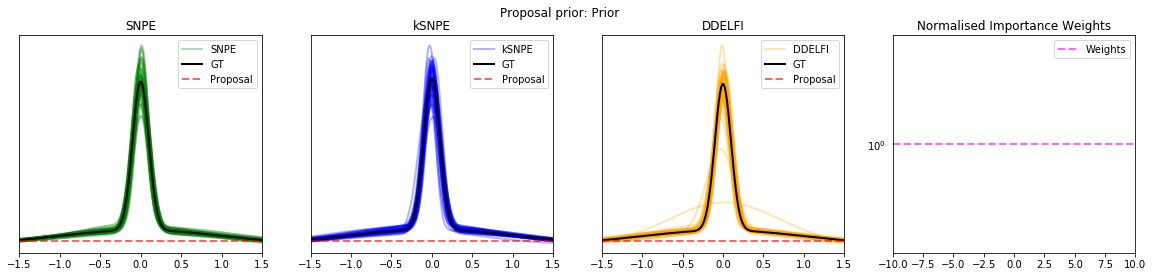

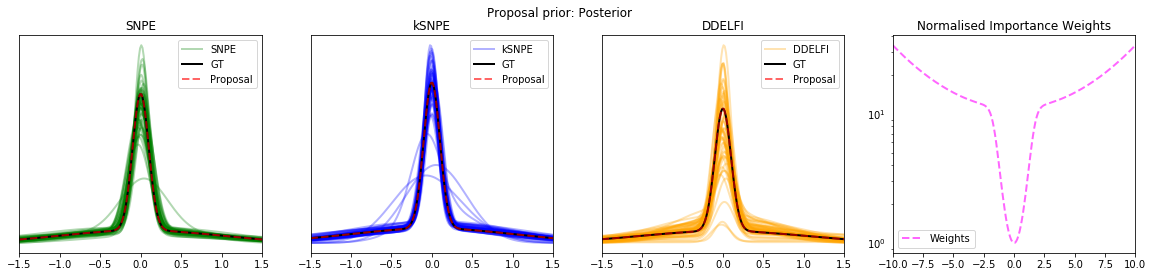

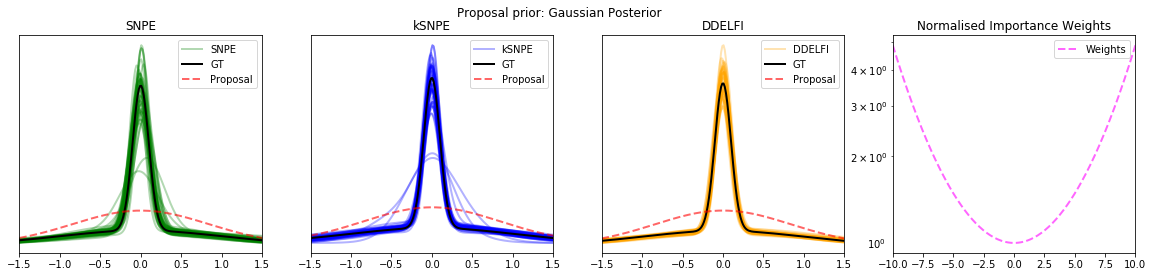

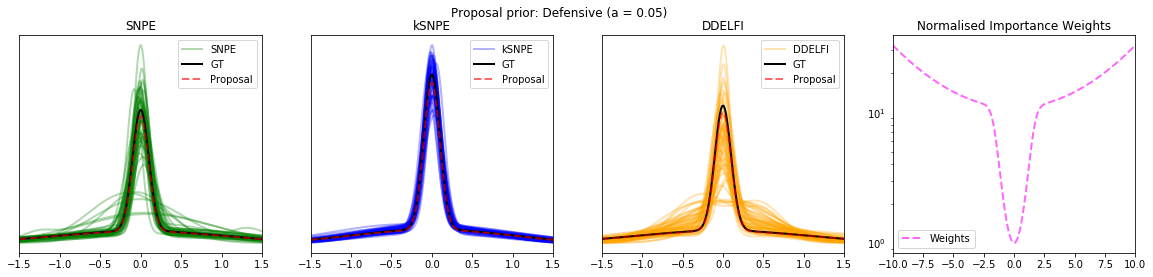

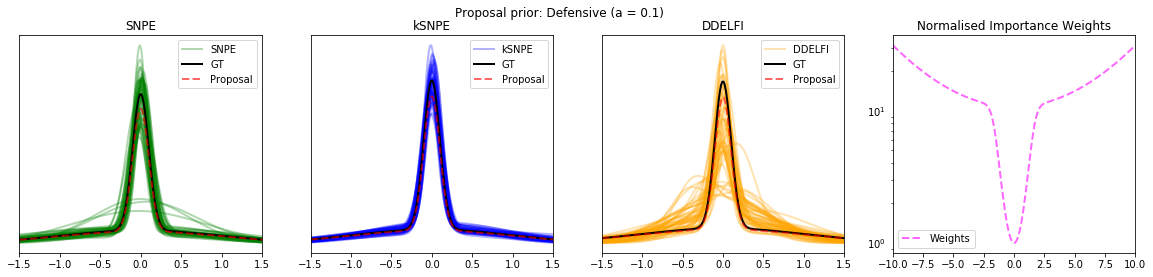

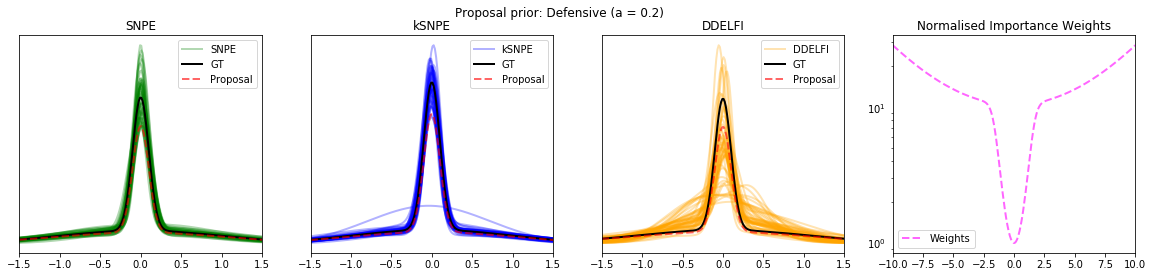

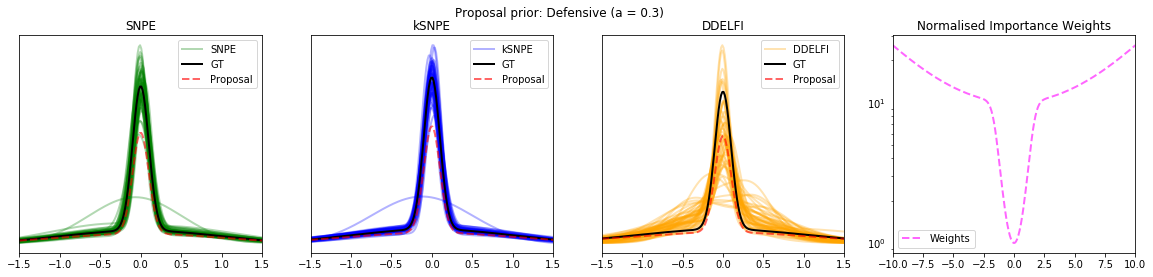

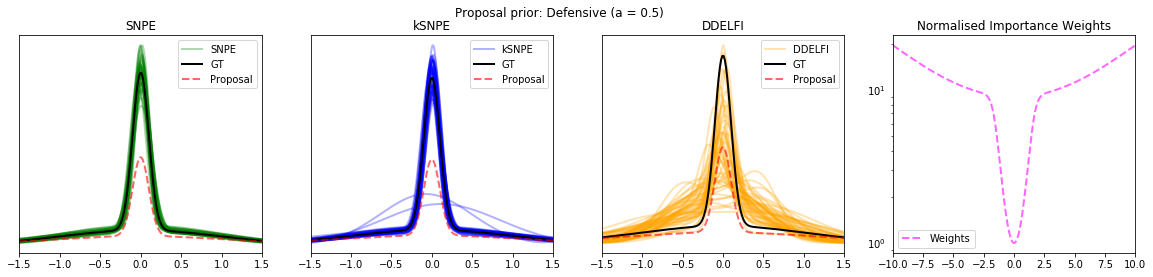

In [106]:
g, _, p_true = create_model(seed=None, params=params)
COL = { 'DDELFI' : 'orange', 'SNPE' : 'green', 'kSNPE' : 'blue' }

proposals = create_proposals(seed, params)

pdf_filename = "{}/{}.pdf".format(figs_dir, output_prefix)

with PdfPages(pdf_filename) as pdf:
    for proposal_name in proposals:
        proposal = proposals[proposal_name]
        plt.figure(figsize=(5 * (len(algos) + 1),4))

        title = "Proposal prior: {}".format(proposal_name)
        xlist = np.linspace(*params.model.prior_bounds, 200).reshape(-1,1)
        plt.suptitle(title)

        for i, algo in enumerate(algos):
            ax = plt.subplot(1, len(algos) + 1, i+1)

            ax.set_title(algo)

            label = algo
            for out in outs[algo][proposal_name]:
                posterior = out['posteriors'][-1]

                plt.plot(xlist.reshape(-1), posterior.eval(xlist, log=False), COL[algo], alpha=0.3, linewidth=2, label=label)
                label = None

            plt.plot(xlist.reshape(-1), p_true.eval(xlist, log=False), 'k', linewidth=2, label="GT")
            plt.plot(xlist.reshape(-1), proposal.eval(xlist, log=False), 'r', ls='--', alpha=0.6, linewidth=2, label="Proposal")
            
            plt.xlim((params.model.prior_bounds))
            ax.set_yticks([])

            plt.legend()
            plt.tick_params(top='off', left='off', right='off', labelleft='off', labelbottom='on')

        weights = g.prior.eval(xlist, log=False) / proposal.eval(xlist, log=False)
        weights /= np.interp([0], xlist.reshape(-1), weights)
        
            
        ax = plt.subplot(1, len(algos) + 1, len(algos)+1)

        ax.set_title("Normalised Importance Weights")

        
        xlist = np.linspace(-10, 10, 200).reshape(-1,1)
        
        #plt.semilogy(xlist.reshape(-1), p_true.eval(xlist, log=False), 'k', linewidth=2, label="GT")
        #plt.semilogy(xlist.reshape(-1), proposal.eval(xlist, log=False), 'r', ls='--', alpha=0.6, linewidth=2, label="Proposal")

        plt.semilogy(xlist.reshape(-1), weights, 'magenta', ls='--', alpha=0.6, linewidth=2, 
                 label="Weights")

        plt.xlim((-10, 10))
        
        plt.legend()
        plt.tick_params(top='off', left='off', right='off', labelright='off', labelleft='on', labelbottom='on')

        pdf.savefig()
        plt.show()